<a href="https://colab.research.google.com/github/bichu136/CS114.L11.KHCL/blob/master/Banana_Detection_Old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download libraries

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


## Connect to drive

In [ ]:
# Tab này chỉ host chạy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 9.1MB/s 


In [ ]:
!pip install keras==2.1.5

     |████████████████████████████████| 337kB 8.2MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
!pip install keras==2.1.5

  Using cached https://files.pythonhosted.org/packages/ba/65/e4aff762b8696ec0626a6654b1e73b396fcc8b7cc6b98d78a1bc53b85b48/Keras-2.1.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.6
Requires: protobuf, wheel, opt-einsum, six, keras-preprocessing, termcolor, google-pasta, gast, wrapt, astor, keras-applications, tensorboard, tensorflow-estimator, absl-py, grpcio, numpy
Required-by: stable-baselines, magenta, fancyimpute


In [ ]:
tf.__version__

'1.15.2'

In [ ]:
import keras as kr
kr.__version__

Using TensorFlow backend.


'2.1.5'

## Import dependencies

In [ ]:
import cv2
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
import os
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import skimage.draw

## Download Mask RCNN library

In [ ]:
!git clone https://www.github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 38.95 MiB/s, done.
Resolving deltas: 100% (560/560), done.


## Check files

In [ ]:
# Tab này chỉ host chạy
path_dir = '/content/drive/My Drive/Train/'

In [ ]:
train_file = [f for f in listdir(path_dir) if isfile(join(path_dir, f))]

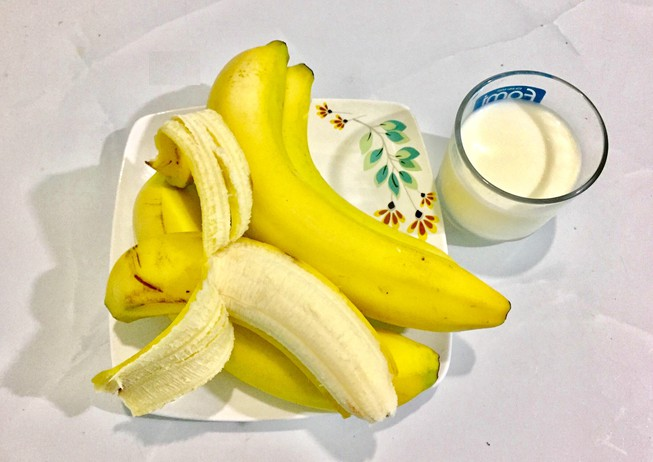

In [ ]:
sample = cv2.imread(path_dir + '1.jpg')
cv2_imshow(sample)

In [ ]:
os.chdir('/content/Mask_RCNN')

In [ ]:
ROOT_DIR = '/content/project'

## Import MaskRCNN dependencies

In [ ]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
sys.path

['/tensorflow-1.15.2/python3.6',
 '',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/project/Mask_RCNN',
 '/content']

## Create Configuration class for Detector

In [ ]:
class DetectorConfig(Config):    
    NAME = 'banana'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 fruit class
    
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 25
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Extend existing Dataset class to customize methods

In [ ]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """
    
    def load_labels(self, labels_list):
        for i, label in enumerate(labels_list):
            self.add_class('fruits', i + 1, label)
            
    def load_dataset(self, images_obj):
        for image_obj in images_obj:
            image_id = image_obj['image_id']
            image_path = image_obj['image_path']
            num_ids = image_obj['num_ids']
            polygons = image_obj['polygons']
            width = image_obj['width']
            height = image_obj['height']
            self.add_image("fruits", image_id=image_id, path=image_path,
                           width=width, height=height, polygons=polygons,num_ids=num_ids)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
    
    # def load_image()  # edit here to change method's behavior

In [ ]:
train_image_path = os.path.join('/content/drive/My Drive/', 'train_trial')
test_image_path = os.path.join('/content/drive/My Drive/', 'test_trial')

## Convert xml file information to dict

In [ ]:
!pip install xmltodict

In [ ]:
labels = ["banana"]

In [ ]:
def parse_single_annotation(label_obj):
    #print(label_obj)
    name = label_obj['name']
    # Get label
    num_id = labels.index(name) + 1
    bb_box = label_obj['bndbox']
    # Extract the xmin xmax ymin and ymax of bounding box
    xmin = int(bb_box['xmin'])
    xmax = int(bb_box['xmax'])
    ymin = int(bb_box['ymin'])
    ymax = int(bb_box['ymax'])
    # Convert it into polygon format. So we need 5 points for both x and y
    all_points_x = [xmin, xmax, xmax, xmin, xmin]
    all_points_y = [ymin, ymin, ymax, ymax, ymin]
    return all_points_x, all_points_y, num_id

## Parse the images and annotations and it in a single array

In [ ]:
import xmltodict
import json
train_images = []
def transform_annotations(image_path):
    # Start the index from 100
    curr_idx = 100
    images_list = []
    c=0
    # List the files in the training or test path
    for i in os.listdir(os.path.join(image_path)):
        
        # Get the image path
        img_path = os.path.join(image_path, i)
        split_img_path = i.split('.')
        # check if the file is a .jpg ext. We ignore .xml file as they will be parsed based on .jpg file name
        if split_img_path[1] in ['jpg','JPG']:
            # Define dict key value pair required in coco dataset
            polygons = []
            num_ids = []
            # Read the image file 
            # file_data = cv2.imread(img_path)
            # Get the heigh and width. OpenCV shape is in the format h, w, depth
            height, width = 0,0
            # Open the xml file which has the same name of the image we have opened for this iteration
            with open(os.path.join(image_path, split_img_path[0] + '.xml')) as fd:
                # Load the xml -> convert xml to dict -> convert to json
                bb_file = json.loads(json.dumps(xmltodict.parse(fd.read())))
                # Get the heigh and width. OpenCV shape is in the format h, w, depth
                height, width = int(bb_file['annotation']['size']['height']),int(bb_file['annotation']['size']['width'])
                # There are two case - bb_file['annotation']['object'] can exist as a single dict or as a list of dict.
                # Thus, we need to do a check to see whether it is a list or not.
                # If the value is a data type of list:
                if isinstance(bb_file['annotation']['object'], list):
                    # Loop through each dict in the list
                    for obj in bb_file['annotation']['object']:
                        # Parse each annotation individually
                        all_points_x, all_points_y, num_id = parse_single_annotation(obj)
                        # Append the points into polygon list
                        polygons.append({
                            'all_points_x': all_points_x,
                            'all_points_y': all_points_y
                        })
                        # Append the id into the num_ids list
                        num_ids.append(num_id)
                # If the ['object'] key only contains a dict value
                else:
                    # We just need to parse a single annotation
                    all_points_x, all_points_y, num_id = parse_single_annotation(bb_file['annotation']['object'])
                    # Append it into polygon and num_ids list
                    polygons.append({
                        'all_points_x': all_points_x,
                        'all_points_y': all_points_y
                    })
                    num_ids.append(num_id)
            # For this image, we need to create a dict to represent it and all the corresponding annotations represented by polygons and num_ids key list
            image_label = {
                'image_path': img_path,
                'image_id': curr_idx,
                'polygons': polygons,
                'num_ids': num_ids,
                'height': height,
                'width': width
            }
            curr_idx = curr_idx + 1
            # Append it into the images_list
            images_list.append(image_label)
            c+=1
    print(c)
    return images_list

# Store annotations into the respective train and test datase

## Load the training dataset and prepare

In [ ]:
train_images = transform_annotations(train_image_path)
print(train_images[0:5])
dataset_train = DetectorDataset()
dataset_train.load_labels(labels)
dataset_train.load_dataset(train_images)
dataset_train.prepare()

213
[{'image_path': '/content/drive/My Drive/train_trial/IMG_20201201_171657.jpg', 'image_id': 100, 'polygons': [{'all_points_x': [1311, 1783, 1783, 1311, 1311], 'all_points_y': [1272, 1272, 2012, 2012, 1272]}, {'all_points_x': [1673, 2495, 2495, 1673, 1673], 'all_points_y': [1209, 1209, 1734, 1734, 1209]}, {'all_points_x': [2045, 2833, 2833, 2045, 2045], 'all_points_y': [1284, 1284, 2022, 2022, 1284]}, {'all_points_x': [2820, 3464, 3464, 2820, 2820], 'all_points_y': [1187, 1187, 2194, 2194, 1187]}, {'all_points_x': [3245, 3873, 3873, 3245, 3245], 'all_points_y': [1247, 1247, 2022, 2022, 1247]}, {'all_points_x': [1014, 1680, 1680, 1014, 1014], 'all_points_y': [1006, 1006, 1672, 1672, 1006]}, {'all_points_x': [398, 1445, 1445, 398, 398], 'all_points_y': [1341, 1341, 2184, 2184, 1341]}], 'num_ids': [1, 1, 1, 1, 1, 1, 1], 'height': 3000, 'width': 4000}, {'image_path': '/content/drive/My Drive/train_trial/IMG_0895.JPG', 'image_id': 101, 'polygons': [{'all_points_x': [625, 2694, 2694, 625, 

## Load the test dataset and prepare

In [ ]:
test_images = transform_annotations(os.path.join(test_image_path))
dataset_val = DetectorDataset()
dataset_val.load_labels(labels)
dataset_val.load_dataset(test_images)
dataset_val.prepare()

91


In [ ]:
len(train_images)

213

In [ ]:
len(test_images)

91

In [ ]:
# count1 = 0
# for i in range(len(train_images)):
#     # image_id = train_images[i]['image_id']
#     # print(train_images[i]['image_path'])
#     mask, num_id = dataset_train.load_mask(i)
#     img_data = cv2.imread(train_images[i]['image_path'])
#     h, w, _ = img_data.shape
#     true_h,true_w = train_images[i]['height'],train_images[i]['width']
#     # print(h,w,true_h,true_w)
#     if (h, w) != (true_h, true_w):
#       # print('need_rotate')
#       count1 += 1
#     # num_id = [x - 1 for x in num_id]
#     # visualize.display_top_masks(img_data, mask, num_id, labels)
# count1

In [ ]:
# count2 = 0
# for i in range(len(test_images)):
#     # image_id = test_images[i]['image_id']
#     # print(test_images[i]['image_path'])
#     mask, num_id = dataset_val.load_mask(i)
#     img_data = cv2.imread(test_images[i]['image_path'])
#     h, w, _ = img_data.shape
#     true_h,true_w = test_images[i]['height'],test_images[i]['width']
#     # print(h,w,true_h,true_w)
#     if (h, w) != (true_h, true_w):
#       # print('need_rotate')
#       count2 += 1
#     # num_id = [x - 1 for x in num_id]
#     # visualize.display_top_masks(img_data, mask, num_id, labels)
# count2

# Start training

### Download the coco weights

In [ ]:
!cd /content && mkdir project
sys.path.append(ROOT_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
!pwd

/content/Mask_RCNN


### Create the model with the specified configuration defined at the top of the file

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


## Load the weights of the COCO dataset

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Now we can start training the actual dataset

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_train, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/project/logs/banana20210124T1028/mask_rcnn_banana_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4 

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/30
24/25 [===========================>..] - ETA: 2s - loss: 2.6161 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.8451 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 1.0164 - mrcnn_mask_loss: 0.4311

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


25/25 [==============================] - 224s 9s/step - loss: 2.5651 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.8317 - mrcnn_class_loss: 0.3035 - mrcnn_bbox_loss: 0.9922 - mrcnn_mask_loss: 0.4248 - val_loss: 1.7243 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.5704 - val_mrcnn_class_loss: 0.2184 - val_mrcnn_bbox_loss: 0.5321 - val_mrcnn_mask_loss: 0.3943

Epoch 2/30
25/25 [==============================] - 133s 5s/step - loss: 1.6562 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5901 - mrcnn_class_loss: 0.1953 - mrcnn_bbox_loss: 0.4655 - mrcnn_mask_loss: 0.3899 - val_loss: 1.6249 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.5279 - val_mrcnn_class_loss: 0.2159 - val_mrcnn_bbox_loss: 0.4915 - val_mrcnn_mask_loss: 0.3779
Epoch 3/30
25/25 [==============================] - 125s 5s/step - loss: 1.4918 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5015 - mrcnn_class_loss: 0.2020 - mrcnn_bbox_loss: 0.4435 - mrcnn_mask_loss: 0.3373 - val_loss: 1.3695 - val_rpn_class_loss: 0.0093 - va

## Visualize image output

In [ ]:
os.listdir(MODEL_DIR)

['banana20210124T1028']

In [ ]:
dir_names = os.listdir(MODEL_DIR)
dir_names = sorted(dir_names)

fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(MODEL_DIR, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/project/logs/banana20210124T1028/mask_rcnn_banana_0030.h5


In [ ]:
model

## Create inference configuration

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/project/logs/banana20210124T1028/mask_rcnn_banana_0030.h5
Re-starting from epoch 30


## Save model

In [ ]:
def custom_save_model(saved_model, current_dir):
  path_dir = '/content/drive/MyDrive/saved_model/banana/Hyperparameter Tuning Model'
  os.chdir(path_dir)
  saved_model.keras_model.save('model_1024_2_101.h5')
  os.chdir(current_dir)

In [ ]:
!pwd

/content/Mask_RCNN


In [ ]:
custom_save_model(model, '/content/Mask_RCNN')

In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    class_ids = [x - 1 for x in class_ids]
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

## Predict output

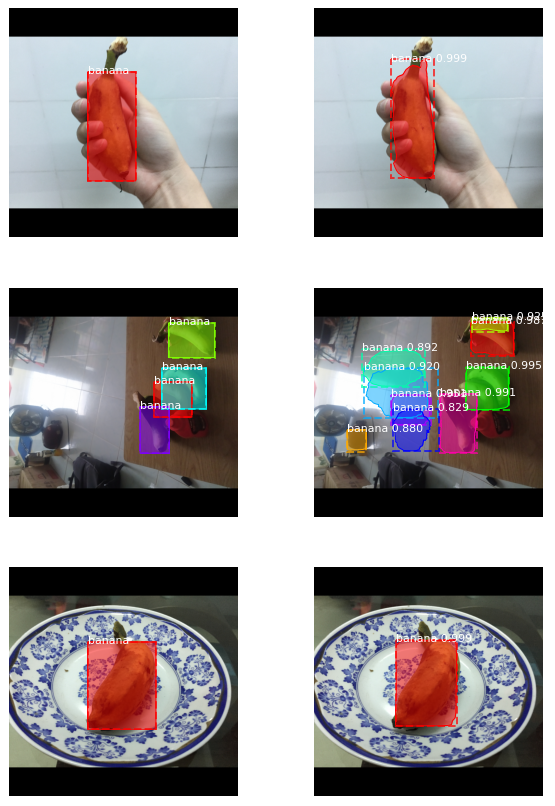

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))
start_idx = 0
for i in range(start_idx, start_idx + 3):
    
    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    plt.subplot(6, 2, 2*(i-start_idx) + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*(i-start_idx) + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])